In [1]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer
from utils import prepare_device
from experiments import get_experiment_config

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
args = argparse.ArgumentParser(description='PyTorch Template')
args.add_argument('-c', '--config', default=None, type=str,
                      help='config file path (default: None)')
args.add_argument('-r', '--resume', default=None, type=str,
                      help='path to latest checkpoint (default: None)')
args.add_argument('-d', '--device', default=None, type=str,
                  help='indices of GPUs to enable (default: all)')
# args.add_argument("-e", "--exp", type=int, required=True, help="Experiment id")
# args
# args.c = "config.json"
# 

args = args.parse_args(['-c','config.json',])
args.exp = 0
# batch_size = 10_000
print(args)
print(type(args))
config = ConfigParser.from_args(args)
config = get_experiment_config(config, config['id'])
# config['data_loader']['args']["additional_feature_names"] =  []
print(config.__dict__)

Namespace(config='config.json', resume=None, device=None, exp=0)
<class 'argparse.Namespace'>
Experiment 0 / 112:
                USE_ECG: True
                USE_HRV: True
                USE_FEATURES: True
                HRV_DURATION: 5m
                ECG_DURATION: 30s
                ADDITIONAL_FEATURES: ['newmultifracs', 'shannon_encoding', 'autoreg']                
{'_config': OrderedDict([('name', 'MyTraining'), ('n_gpu', 1), ('arch', OrderedDict([('type', 'MyModel'), ('args', OrderedDict([('use_ecg_time_series', True), ('use_hrv_time_series', True), ('use_features', True)]))])), ('data_loader', OrderedDict([('type', 'MyDataLoader'), ('args', OrderedDict([('data_dir', 'data/data_patient'), ('batch_size', 32), ('shuffle', True), ('validation_split', 0.2), ('num_workers', 2), ('features_duration', '5m'), ('hrv_duration', '5m'), ('ecg_duration', '30s'), ('additional_feature_names', ['newmultifracs', 'shannon_encoding', 'autoreg'])]))])), ('optimizer', OrderedDict([('type', 'Ada

In [4]:
# data_loader.dataset.get_feature_size()

In [5]:
data_loader = config.init_obj('data_loader', module_data)

In [6]:
# data_loader = getattr(module_data, config['data_loader']['type'])(
#         config['data_loader']['args']['data_dir'],
#         batch_size=512,
#         shuffle=False,
#         validation_split=0.0,
#         training=False,
#         num_workers=2
#     )

config['arch']['args']['feature_size'] = data_loader.dataset.get_feature_size()
config['arch']['args']['num_classes'] = data_loader.dataset.get_num_classes()

# build model architecture
model = config.init_obj('arch', module_arch)
# logger.info(model)

# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

# logger.info('Loading checkpoint: {} ...'.format(config.resume))
checkpoint = torch.load("saved/models/MyTraining/0/0926_144845/model_best.pth") # config.resume)
state_dict = checkpoint['state_dict']
# if config['n_gpu'] > 1:
#     model = torch.nn.DataParallel(model)
# state_dict = 
model.load_state_dict(state_dict)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()



MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hrv_conv): ConvNet(
    (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
    (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv5): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv6): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv7): Conv1d(32, 256, kernel_size=(3,), stride=(1,))
    (conv8): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (global_maxpool): AdaptiveMaxPool1d(output_size=1)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=256, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
  )
  (ecg_conv): ConvNe

In [7]:
total_loss = 0.0
total_metrics = torch.zeros(len(metric_fns))

outputs = []
inputs = []
inputs_ecg = []
inputs_hrv = []
outputs1 = []
outputs2 = []
outputs3 = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(data_loader)):
        # data, target = data.to(device), target.to(device)

        out1 = model.flatten(model.ecg_conv(data["ecg_time_series"]))
        out2 = model.flatten(model.hrv_conv(data["hrv_time_series"]))

        features = model.features(data["features"])
    
        concat = torch.cat([model.flatten(out1), model.flatten(out2), features],dim=-1)
        outputs.append(concat)
        
        labels.append(target)
        inputs.append(data)
        inputs_ecg.append(data["ecg_time_series"])
        inputs_hrv.append(data["hrv_time_series"])
        outputs1.append(out1)
        outputs2.append(out2)
        outputs3.append(features)
        #
        # save sample images, or do something with output here
        #

        # computing loss, metrics on test set
        # loss = loss_fn(output, target)
        # batch_size = data.shape[0]
        # total_loss += loss.item() * batch_size
        # for i, metric in enumerate(metric_fns):
        #     total_metrics[i] += metric(output, target) * batch_size

# inputs = torch.cat(inputs)
inputs_ecg = torch.cat(inputs_ecg,dim=0)
inputs_hrv = torch.cat(inputs_hrv,dim=0)
outputs = torch.cat(outputs,dim=0)
outputs1 = torch.cat(outputs1,dim=0)
outputs2 = torch.cat(outputs2,dim=0)
outputs3 = torch.cat(outputs3,dim=0)

labels = torch.cat(labels,dim=0)
labels = np.array(labels)

100%|██████████| 161/161 [00:41<00:00,  3.88it/s]


## Entropy estimation

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [9]:
import numpy as np
import math

import torch
import torch.nn as nn


In [10]:
from model.my_model import ConvNet
import copy

In [11]:
class MyDataset(Dataset):

    def __init__(self, X, Y, labels):
        self.X = X
        self.Y = Y
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return the features and corresponding label at the given index
        return self.X[idx], self.Y[idx], self.labels[idx]

In [12]:
convnet = copy.deepcopy(model.ecg_conv)

In [13]:
class CLUB(nn.Module):  # CLUB: Mutual Information Contrastive Learning Upper Bound
    '''
        This class provides the CLUB estimation to I(X,Y)
        Method:
            forward() :      provides the estimation with input samples
            loglikeli() :   provides the log-likelihood of the approximation q(Y|X) with input samples
        Arguments:
            zc_dim, zd_dim :         the dimensions of samples from X, Y respectively
            hidden_size :          the dimension of the hidden layer of the approximation network q(Y|X)
            z_c, z_d : samples from X and Y, having shape [sample_size, zc_dim/zd_dim]
    '''

    def __init__(self, zc_dim, zd_dim): # args,
        super(CLUB, self).__init__()
        self.use_tanh = False
        # self.p_mu = FF(args, zc_dim, zc_dim, zd_dim)
        # self.p_logvar = FF(args, zc_dim, zc_dim, zd_dim)
        self.p_mu = nn.Sequential(nn.Linear(zc_dim, zd_dim),
                                      nn.ReLU(),
                                      nn.Linear(zd_dim, zd_dim),
                                    )
        self.p_logvar = nn.Sequential(nn.Linear(zc_dim, zd_dim),
                                      nn.ReLU(),
                                      nn.Linear(zd_dim, zd_dim),
                                      nn.Tanh())

    def get_mu_logvar(self, z_c):
        mu = self.p_mu(z_c)
        logvar = self.p_logvar(z_c)
        if self.use_tanh:
            logvar = logvar.tanh()
        return mu, logvar

    def forward(self, z_c, z_d):
        mu, logvar = self.get_mu_logvar(z_c)

        # log of conditional probability of positive sample pairs
        positive = - (mu - z_d) ** 2 / 2. / logvar.exp()

        prediction_1 = mu.unsqueeze(1)  # shape [nsample,1,dim]
        z_d_1 = z_d.unsqueeze(0)  # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((z_d_1 - prediction_1) ** 2).mean(dim=1) / 2. / logvar.exp()
        mi = (positive.sum(-1) - negative.sum(-1)).mean()
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d):  # unnormalized loglikelihood
        mu, logvar = self.get_mu_logvar(z_c)
        return -(-(mu - z_d) ** 2 / logvar.exp() - logvar).sum(1).mean(0)

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]


In [14]:
class MyClub(nn.Module):
    def __init__(self,zc_dim, zd_dim, sample=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv = ConvNet()
        if sample:
            # self.club = CLUBSample(x_dim=x_dim, y_dim=y_dim, hidden_size=32)
            self.club = CLUB(zc_dim=zc_dim, zd_dim=zd_dim)
        else:
            self.club = CLUB(zc_dim=zc_dim, zd_dim=zd_dim)

    def get_mu_logvar(self, z_c):
        z_c = self.conv(z_c)
        return self.club.get_mu_logvar(z_c)

    def forward(self, z_c, z_d):
        mu, logvar = self.get_mu_logvar(z_c)

        # log of conditional probability of positive sample pairs
        positive = - (mu - z_d) ** 2 / 2. / logvar.exp()

        prediction_1 = mu.unsqueeze(1)  # shape [nsample,1,dim]
        z_d_1 = z_d.unsqueeze(0)  # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((z_d_1 - prediction_1) ** 2).mean(dim=1) / 2. / logvar.exp()
        mi = (positive.sum(-1) - negative.sum(-1)).mean()
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d):  # unnormalized loglikelihood
        mu, logvar = self.get_mu_logvar(z_c)
        return -(-(mu - z_d) ** 2 / logvar.exp() - logvar).sum(1).mean(0)

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]

In [15]:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho ** 2)
    return result


def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

In [16]:
import time

In [17]:
from myknife import MyKNIFE

In [18]:
def main(cubic=True):
    # import os
    # os.environ['CUDA_VISIBLE_DEVICES'] = '2'

    #for seed in [1, 2 ,3, 4, 5, 6, 7, 8]:
    # set_seed(seed)
    lambda_ = 2

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    # suffix = '9.07_{}_{}_{}'.format(cubic, lambda_, seed)
    suffix = "test"
    # sample_dim = 20
    batch_size = 64
    # hidden_size = 15
    learning_rate = 0.001
    training_steps = 50_000
    model_list =  ["MyKnife"]# ["MyClub"]  #"TUBA", "KNIFE" # CLUBSample

    mi_list = [2.0] #, 4.0, 6.0, 8.0, 10.0]  # , 12.0, 14.0, 16.0, 18.0, 20.0]

    total_steps = training_steps * len(mi_list)
    
    dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))
    train_ratio = 0.8
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for the training and testing sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_iter = iter(test_loader)
    # train MI estimators with samples

    # train MI estimators with samples

    mi_results = dict()
    for model_name in tqdm(model_list, 'Models'):
        if model_name == "MyClub":
            model = MyClub(zc_dim=32,zd_dim=32)
            model.conv = convnet
        if model_name == "MyKnife":
            model = MyKNIFE(32,4)
            model.kernel_marg = copy.deepcopy(convnet)
            model.kernel_cond = copy.deepcopy(convnet)
        # elif model_name == 'Kernel_F':
        #     model = MIKernelEstimator(device, sample_dim // 2, sample_dim).to(device)
        # elif model_name == 'KNIFE':
        #     model = MIKernelEstimator(device, batch_size // 6, sample_dim, sample_dim, use_joint=True).to(device)
        # elif model_name == 'DOE':
        #     model = eval(model_name)(sample_dim, sample_dim).to(device)
        # else:
        #     model = eval(model_name)(sample_dim, sample_dim, hidden_size).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

        mi_est_values = []
        test_mi_est_values = []
        test_mean_mi_est_values = []
        step = 0
        start_time = time.time()
        epochs = 60
        for epoch in tqdm(range(epochs), 'epoch'):
            # rho = mi_to_rho(mi_value, sample_dim)
            for batch_x, batch_y, batch_label in train_loader:
                # print(batch_x.shape)
                # print(batch_y.shape)
            # for step in tqdm(range(training_steps), 'Training Loop', position=0, leave=True):
            #     batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size=batch_size,
            #                                                     to_cuda=torch.cuda.is_available(), cubic=cubic)
                # batch_x = torch.tensor(batch_x).float().to(device)
                # batch_y = torch.tensor(batch_y).float().to(device)
                model.eval()
                mi_est, _, _ = model(batch_x, batch_y, batch_label)
                mi_est_values.append(mi_est.item())

                model.train()

                model_loss = model.learning_loss(batch_x, batch_y, batch_label)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()

                del batch_x, batch_y, batch_label
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                step += 1
                if step % 50 == 0:
                    step = 0
                    with torch.no_grad():
                        s = 0.
                        n = 0
                        for batch_x, batch_y, batch_label in test_loader:
                            n += 1
                            model.eval()
                            mi_est, _, _ = model(batch_x, batch_y, batch_label)
                            s += mi_est
                            test_mi_est_values.append(mi_est.item())
                        test_mean_mi_est_values.append(s/n)
                    del batch_x, batch_y, batch_label

            #print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
            # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        end_time = time.time()
        time_cost = end_time - start_time
        print("model %s average time cost is %f s" % (model_name, time_cost / total_steps))
        mi_results[model_name] = mi_est_values
        # plt.plot(mi_est_values)
        # plt.plot(test_mi_est_values)
        plt.plot(test_mean_mi_est_values,color='r')
        plt.show()

    import seaborn as sns
    import pandas as pd

    colors = sns.color_palette()

    EMA_SPAN = 200

    ncols = len(model_list)
    nrows = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 * ncols, 3.4 * nrows))
    axs = np.ravel(axs)

    xaxis = np.array(list(range(total_steps)))
    yaxis_mi = np.repeat(mi_list, training_steps)

    for i, model_name in enumerate(model_list):
        plt.sca(axs[i])
        p1 = plt.plot(mi_results[model_name], alpha=0.4, color=colors[0])[0]  # color = 5 or 0
        plt.locator_params(axis='y', nbins=5)
        plt.locator_params(axis='x', nbins=4)
        mis_smooth = pd.Series(mi_results[model_name]).ewm(span=EMA_SPAN).mean()

        if i == 0:
            plt.plot(mis_smooth, c=p1.get_color(), label='$\\hat{I}$')
            plt.plot(yaxis_mi, color='k', label='True')
            plt.xlabel('Steps', fontsize=25)
            plt.ylabel('MI', fontsize=25)
            plt.legend(loc='upper left', prop={'size': 15})
        else:
            plt.plot(mis_smooth, c=p1.get_color())
            plt.yticks([])
            plt.plot(yaxis_mi, color='k')
            plt.xlabel('Steps', fontsize=25)

        # plt.ylim(0, 15.5)
        plt.xlim(0, total_steps)
        plt.title(model_name, fontsize=35)
        import matplotlib.ticker as ticker

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        plt.xticks(horizontalalignment="right")
        # plt.subplots_adjust( )

    plt.gcf().tight_layout()
    # plt.savefig('mi_est_Gaussian_{}_copy.pdf'.format(suffix), bbox_inches=None)
    # plt.show()

    print('Second part')

    bias_dict = dict()
    var_dict = dict()
    mse_dict = dict()
    for i, model_name in tqdm(enumerate(model_list)):
        bias_list = []
        var_list = []
        mse_list = []
        for j in range(len(mi_list)):
            mi_est_values = mi_results[model_name][training_steps * (j + 1) - 500:training_steps * (j + 1)]
            est_mean = np.mean(mi_est_values)
            bias_list.append(np.abs(mi_list[j] - est_mean))
            var_list.append(np.var(mi_est_values))
            mse_list.append(bias_list[j] ** 2 + var_list[j])
        bias_dict[model_name] = bias_list
        var_dict[model_name] = var_list
        mse_dict[model_name] = mse_list

    # %%

    plt.style.use('default')  # ('seaborn-notebook')

    colors = list(plt.rcParams['axes.prop_cycle'])
    col_idx = [2, 4, 5, 1, 3, 0, 6, 7]

    ncols = 1
    nrows = 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3. * nrows))
    axs = np.ravel(axs)

    for i, model_name in enumerate(model_list):
        plt.sca(axs[0])
        plt.plot(mi_list, bias_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

        plt.sca(axs[1])
        plt.plot(mi_list, var_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

        plt.sca(axs[2])
        plt.plot(mi_list, mse_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

    ylabels = ['Bias', 'Variance', 'MSE']
    for i in range(3):
        plt.sca(axs[i])
        plt.ylabel(ylabels[i], fontsize=15)

        if i == 0:
            if cubic:
                plt.title('Cubic', fontsize=17)
            else:
                plt.title('Gaussian', fontsize=17)
        if i == 1:
            plt.yscale('log')
        if i == 2:
            plt.legend(loc='upper left', prop={'size': 12})
            plt.xlabel('MI Values', fontsize=15)

    plt.gcf().tight_layout()
    # plt.savefig('bias_variance_Gaussian_{}.pdf'.format(suffix), bbox_inches='tight')
    # plt.show()

epoch: 100%|██████████| 60/60 [2:17:35<00:00, 137.58s/it]


model MyKnife average time cost is 0.165101 s


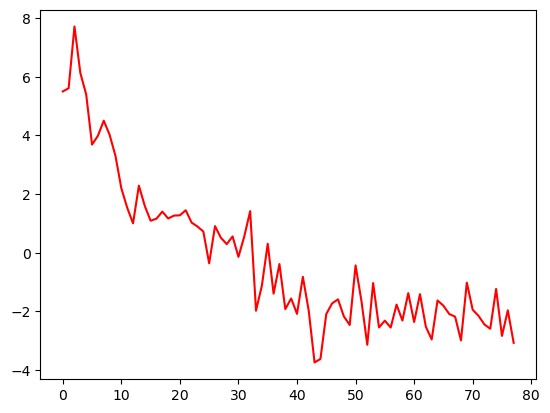

Models: 100%|██████████| 1/1 [2:17:35<00:00, 8255.77s/it]


Second part


0it [00:00, ?it/s]c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
1it [00:00, 124.96it/s]


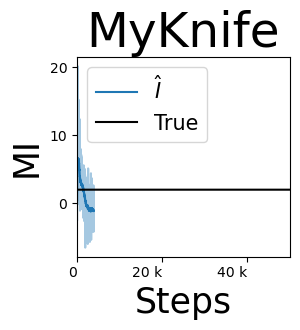

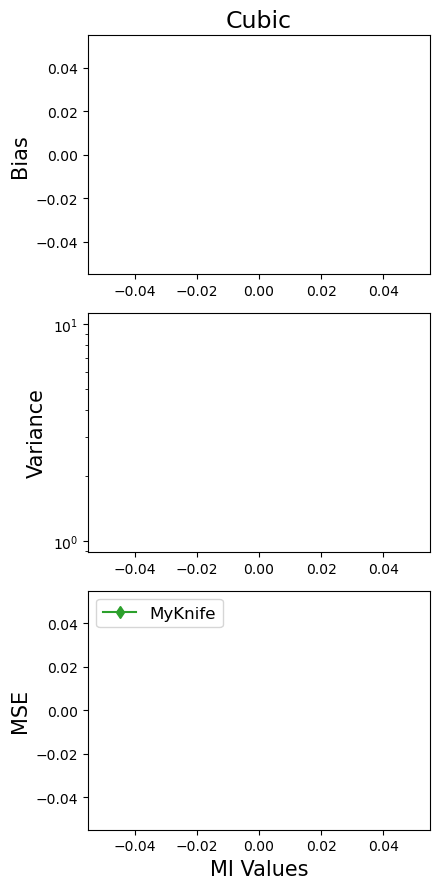

In [19]:
main()